 We first need to load the data *heart.dat* and create matrix of observations $X$ and clasification $Y$.

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import random as r
from timeit import default_timer as timer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
data= pd.read_csv('/content/drive/My Drive/Colab Notebooks/nt_toolbox/data/heart.dat',sep=" ", header=None)
print(data.shape)
nameData = data.copy()
nameData.columns = ['Age', 'Sex','ChestPainType','RestBloodPressure','SerumCholestoral','FastingBloodSugar',
                   'RestingElectrocardResult','MaxHeartRate','ExerciseInducedAngina',
                   'Oldpeak','SlopePeak','NumMajorVessels', 'thalCode','HeartDisease']
nameData.head() # Preview Data

(270, 14)


,Age,Sex,ChestPainType,RestBloodPressure,SerumCholestoral,FastingBloodSugar,RestingElectrocardResult,MaxHeartRate,ExerciseInducedAngina,Oldpeak,SlopePeak,NumMajorVessels,thalCode,HeartDisease
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


In [0]:
heart = '/content/drive/My Drive/Colab Notebooks/nt_toolbox/data/heart.dat'
data=np.loadtxt(heart, unpack=True)

## Data training

In [0]:
#Converting the data to X and Y
A=np.transpose(data[0:-1])[0:220]
(n,m)=A.shape
Y=np.transpose(2*(data[-1][0:220]-1.5*np.ones(n)))
T=[[0 for x in range(m+1)] for y in range(n)]
X=np.array(T)
for i in range(n):
    for j in range(m):
        X[i][j]=A[i][j]
for i in range(n):
    X[i][m]=1
#prettyP(X)
#prettyP(Y)

In this part, we consider the support vector machine problem:
\begin{equation}
\min_{w\in\mathbb{R}^m}\varphi(w):=\frac{\lambda}{2}\Vert w\Vert^2+\frac{1}{n}\sum_{i=1}^n \max\{0, 1-y_iw^Tx_i\} \quad\text{ with } \lambda=0.00001
\end{equation}

## Subgradient descent method

The subdifferential of $\varphi$ is 
$
\partial \varphi(w)= \lambda w+\frac{1}{n}\sum_{i=1}^n\partial f_i(w),
$
where
$$
\partial f_i(w)=\begin{cases} 0 & \text{ if } 1-y_iw^Tx_i<0,\\
-[0,1]\times y_ix_i & \text{ if } 1-y_iw^Tx_i=0,\\
-y_ix_i & \text{ otherwise}.
\end{cases}
$$
The subgradient descent method
1. Initialize: $w=(1,1,\cdots,1)$
2. Iteration: 
Choose $v_k\in\partial \varphi(x^k)$, then
$$x^{k+1}=x^k-\dfrac{1}{\sqrt{k+1}}v_k$$


In [0]:
#Choosing a subgradient
def subdiff(w,matrix,u,col):
    (n,m)= matrix.shape
    v=0.00001*w
    for i in range(n):
        c = col[i]*np.matmul(np.transpose(w),np.transpose(matrix[i][:]))
        if (1-c)<0:
            u=np.zeros(m)
        elif (1-c)>0:
            u=-col[i]*np.transpose(matrix[i][:])
        else:
            u=-r.randrange(0,1)*col[i]*np.transpose(matrix[i][:])
        v +=1/n*u
    return v

In [0]:
def fvalue(matrix,col,w):
    (n,m)=matrix.shape
    v=0.00001/2*np.linalg.norm(w,ord=2)**2
    for i in range(n):
        v += 1/n*max(0, 1-col[i]*np.matmul(np.transpose(w),np.transpose(matrix[i][:])))
    return v

In [0]:
## Subgradient descent method
def regress(matrix,col):
    (n,m)= matrix.shape
    norm=np.linalg.norm(matrix,ord=2)**2
    u = [1 for i in range (m)]
    w = np.zeros(m)
    fbest=100*np.ones(10001)
    a=np.ones(m)
    value=np.ones(10000)
    for i in range(10000):
        v=subdiff(w,matrix,u,col) #choose a subgradient
        w += -1/np.sqrt(i+1)*v# x^{k+1}=x^k-f(x^k)/(norm(v)^2)*v
        value[i]=fvalue(X,Y,w) #compute f(x^{k+1})
        if value[i]<fbest[i]:#store fbest
            fbest[i+1]=value[i]
            a+=-a+w
        else:
            fbest[i+1]=fbest[i]
    return (a, w, value, fbest)

time= 50.82135113700042
value= [ 5457.71896384 11021.94323489  5988.7776683  ...    13.51909805
    13.51942672    13.51799998]
fbest= [100.         100.         100.         ...  13.51909805  13.51909805
  13.51799998]


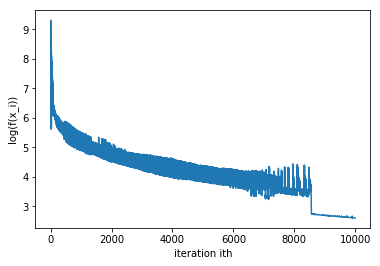

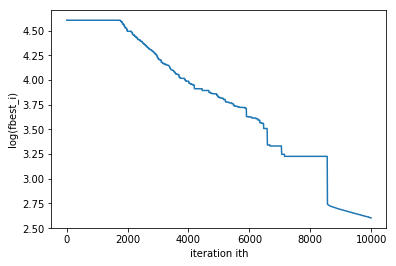

In [0]:
start = timer()
(wbest,gdm,value, fbest)=regress(X,Y)
end = timer()
print('time=',end - start)
#print('x=',x)
print('value=',value)
print('fbest=',fbest)
import matplotlib.pyplot as plt
plt.plot(np.log(value))
plt.xlabel('iteration ith')
plt.ylabel('log(f(x_i))')
plt.show()
plt.plot(np.log(fbest))
plt.xlabel('iteration ith')
plt.ylabel('log(fbest_i)')
plt.show()

## Stochastic subgradient descent method

The stochastic subgradient descent method is
1. Initialize: $w=(1,1,\cdots,1)$
2. Iteration: 
Pick randomly $i\in \{1,\cdots,n\}$, and $v_k\in\partial f_i(x^k)$, then
$$x^{k+1}=x^k-\dfrac{1}{\sqrt{k+1}\Vert v_k\Vert}v_k$$


In [0]:
def subdiffsto(w,matrix,col):
    (n,m)=X.shape
    c = col*np.matmul(np.transpose(w),np.transpose(matrix))
    if (1-c)<0:
        u=np.zeros(m)
    elif (1-c)>0:
        u=-col*np.transpose(matrix)
    else:
        u=-r.randrange(0,1)*col*np.transpose(matrix)
    v =u+0.00001*w
    return v

In [0]:
##Stochastic subgradient descent method
def storegress(matrix,col):
    (n,m)= matrix.shape
    norm=np.linalg.norm(matrix,ord=2)**2
    w=np.ones(m)
    fbest=100*np.ones(100001)
    a=np.ones(m)
    value=np.ones(100000)
    for i in range(100000):
        j=r.randint(0,n-1) #choose randomly j in [0,n-1]
        v=subdiffsto(w,matrix[j][:],col[j]) #choose a subgradient of |a_j'x-b_j|
        w += -1/np.sqrt(i+1)*v #x^{k+1}=x^k-1/(norm(v)*sqrt(i+1))*v
        value[i]=fvalue(X,Y,w)#compute f(x^{k+1})
        if value[i]<fbest[i]:#store fbest
            fbest[i+1]=value[i]
            a=-a+w
        else:
            fbest[i+1]=fbest[i]
    return (a, w, value, fbest)


time= 183.55609853399983
value= [3.82526115e+04 3.82523410e+04 3.82521202e+04 ... 1.79332377e+02
 3.36091421e+01 3.42557521e+01]
fbest= [100.         100.         100.         ...  21.27756495  21.27756495
  21.27756495]


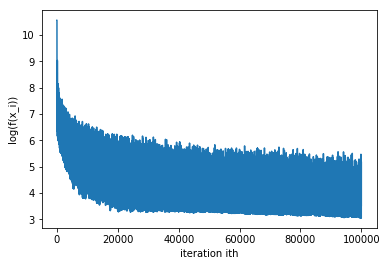

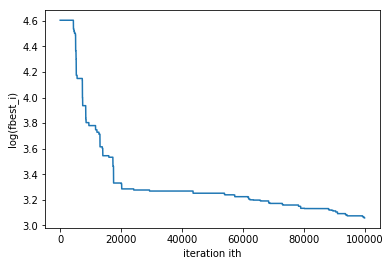

In [0]:
start = timer()
(wstobest,stogdm,value, fbest)=storegress(X,Y)
end = timer()
print('time=',end - start)
#print('x=',x)
print('value=',value)
print('fbest=',fbest)
import matplotlib.pyplot as plt
plt.plot(np.log(value))
plt.xlabel('iteration ith')
plt.ylabel('log(f(x_i))')
plt.show()
plt.plot(np.log(fbest))
plt.xlabel('iteration ith')
plt.ylabel('log(fbest_i)')
plt.show()

## Use test data to examine the result

In [0]:
B=np.transpose(data[0:-1])[220:]
(n,m)=B.shape
print(B.shape)
C=np.transpose(data[-1])[220:]
Test=[[0 for x in range(m+1)] for y in range(n)]
Xtest=np.array(Test)
for i in range(n):
    for j in range(m):
        Xtest[i][j]=B[i][j]
for i in range(n):
    Xtest[i][m]=1
#prettyP(Xtest)
print(C)

(50, 13)
[2. 2. 1. 2. 1. 1. 2. 2. 1. 1. 2. 2. 1. 2. 1. 2. 1. 2. 1. 1. 2. 1. 1. 2.
 1. 2. 2. 1. 2. 2. 2. 1. 2. 1. 1. 1. 1. 2. 2. 1. 1. 2. 2. 1. 2. 1. 1. 1.
 1. 2.]


In [0]:
y1=np.matmul(Xtest,gdm)
y2=np.matmul(Xtest,stogdm)
for i in range(n):
    if y1[i]<0:
        y1[i]=1
    else:
        y1[i]=2
for i in range(n):
    if y2[i]<0:
        y2[i]=1
    else:
        y2[i]=2
print(y1)
print(y2)
count1=0
for i in range(n):
    if y1[i]==C[i]:
        count1+=1
eff1=count1/n
count2=0
for i in range(n):
    if y2[i]==C[i]:
        count2+=1
eff2=count2/n
print('efficientcy1=',eff1)
print('efficientcy2=',eff2)

[2. 2. 1. 2. 1. 2. 2. 2. 1. 1. 2. 2. 1. 2. 2. 2. 1. 2. 1. 1. 2. 1. 1. 1.
 1. 2. 2. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 2. 2. 1. 1.
 2. 2.]
[2. 2. 1. 2. 1. 1. 2. 2. 1. 1. 1. 2. 1. 1. 2. 2. 1. 2. 1. 1. 1. 1. 1. 1.
 1. 2. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1.
 1. 2.]
efficientcy1= 0.82
efficientcy2= 0.78
